##### Install and import packages

In [1]:
!pip install transformers
!pip install emoji

     |████████████████████████████████| 4.0 MB 4.8 MB/s 
     |████████████████████████████████| 84 kB 2.2 MB/s 
     |████████████████████████████████| 596 kB 52.7 MB/s 
     |████████████████████████████████| 6.6 MB 52.1 MB/s 
     |████████████████████████████████| 880 kB 54.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=07598e99cce83eaf573ff24d37fb51f634a9b125a594a2c33dd7a7e3b46798f7
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 175 kB 4.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=07807a2709b4c953fe9ab99d44d35f9e82492937f64cfb7afc84397880647fd0
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01

In [2]:
import tweepy
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils import clip_grad_norm_
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_scheduler
import time
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import csv
plt.rcParams['figure.figsize'] = (20,5)

##### Load Twitter API

In [ ]:
api_key = 'aJTgi4d1H1zmQNkQuHeualNhP'
api_secrets = 'yPFdp2Bbib25r1iPQCqBuPq8B9UzoJbIdpv1jgzEZFEg1eJl6X'
access_token = '1409382627124019204-oPpzVGuCwyFfQTfoocFhgHi68whhog'
access_secret = 'esgwpH5gnRfNB0SpiHkO52mZSI5VKKnn8SG2pafEnzj2b'
 
# Authenticate to Twitter
auth = tweepy.OAuthHandler(api_key,api_secrets)
auth.set_access_token(access_token,access_secret)
api = tweepy.API(auth)
 
try:
    api.verify_credentials()
    print('Successful Authentication')
except:
    print('Failed Authentication')

Successful Authentication


##### Get a list of list of ids where the first id is the source tweet and the others are reply tweets, for the train, development and test sets.

In [3]:
def get_ids(filename):
    file = open(filename)
    threads = file.readlines()
    file.close()
    return [thread.replace('\n', '').split(',') for thread in threads]

def get_labels(filename):    
    file = open(filename)
    labels = file.readlines()
    file.close()
    return [label.replace('\n', '') for label in labels]

In [4]:
train_ids = get_ids('train.data.txt')
train_labels = get_labels('train.label.txt')

dev_ids = get_ids('dev.data.txt')
dev_labels = get_labels('dev.label.txt')

test_ids = get_ids('test.data.txt')

assert len(train_ids) == len(train_labels)
assert len(dev_ids) == len(dev_labels)

print(train_ids[0])
print(train_labels[0])

['1250219300389974016', '1250219116993974272', '1250219437027766273', '1250219620939657216', '1250219777185873922', '1250219894429208577', '1250219998842216448', '1250220115762667520', '1250220272306638848', '1250220389323526146', '1250220527005753344', '1250220791544705025', '1250220987238383616', '1250221140603047937', '1250221275827470336', '1250221402822545410']
nonrumour


In [5]:
# get list of unique ids in train and development sets
flat_train_ids = [id_ for id_list in train_ids for id_ in id_list]
flat_dev_ids = [id_ for id_list in dev_ids for id_ in id_list]
unique_ids = list(set(flat_train_ids + flat_dev_ids))

flat_test_ids = list(set([id_ for id_list in test_ids for id_ in id_list]))

## EXPLORATORY DATA ANALYSIS

##### Check the distribution of classes in the train and development sets.

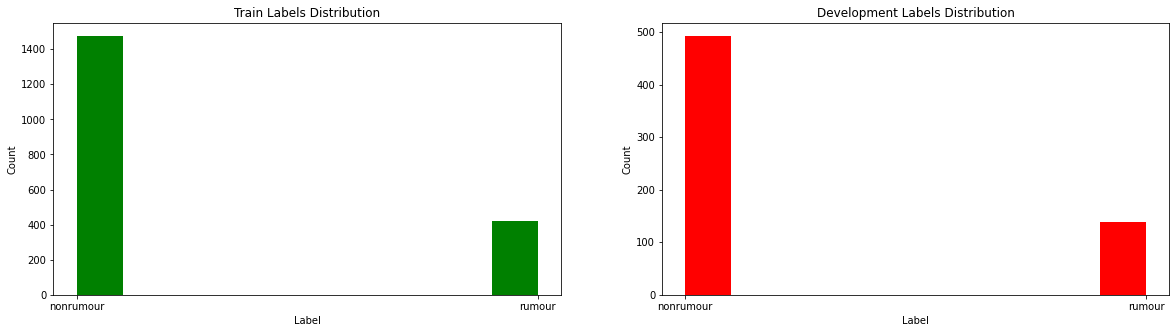

In [ ]:
plt.subplot(1, 2, 1)
plt.hist(train_labels, color='green')
plt.title('Train Labels Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(dev_labels, color='red')
plt.title('Development Labels Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

In [ ]:
train_rumour_percentage = train_labels.count('rumour') / len(train_labels) * 100
dev_rumour_percentage = dev_labels.count('rumour') / len(dev_labels) * 100

print(f'The percentage of rumour labels in the train set is {train_rumour_percentage:.1f}%')
print(f'The percentage of rumour labels in the development set is {dev_rumour_percentage:.1f}%')

The percentage of rumour labels in the train set is 22.2%
The percentage of rumour labels in the development set is 22.0%


Classes are imbalanced, but representative of the ratio of rumour to nonrumour tweets.

In [ ]:
lang_dict = defaultdict(int)

def get_train_tweet_languages_from_api(ids):
    for i in range(0, len(ids), 100):
        split = ids[i:i+100]
        for tweet in api.lookup_statuses(split, tweet_mode='extended'):
            lang_dict[tweet.lang] += 1

In [ ]:
get_train_tweet_languages_from_api(unique_ids)

print(lang_dict['en'])
print(lang_dict['fr'])

24540
97


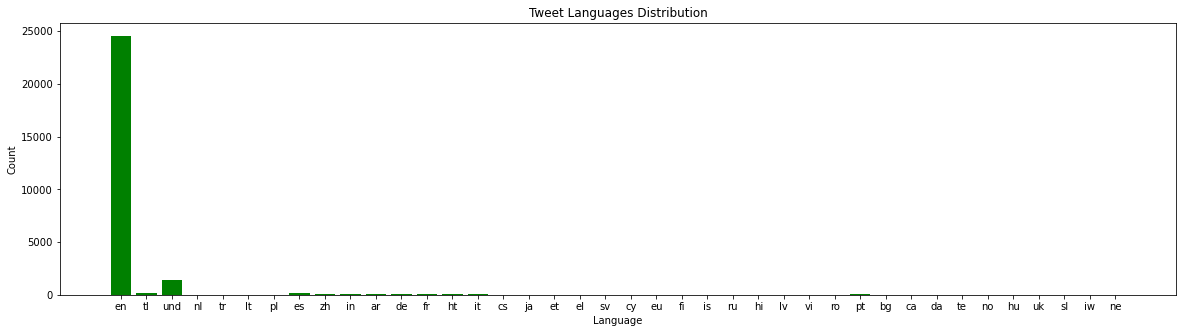

In [ ]:
plt.bar(lang_dict.keys(), lang_dict.values(), color='green')
plt.title('Tweet Languages Distribution')
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()

In [ ]:
en_count = lang_dict['en']
other_count = sum([count for count in lang_dict.values()])

print(f'The percentage of tweets that are in English is {en_count/other_count*100:.1f}%')

The percentage of tweets that are in English is 0.910


Around 91% of tweets are in English; fair choice to use a model pre-trained on English tweets.

## Data Pre-processing

##### Create a dataframe of tweet ids with their full text (for train and development instances) and possibly truncated text (for test instances) and save as a csv file: tweets_id_text.csv.

In [ ]:
# tweet id: full text of tweet if found by api, otherwise text from tweet-objects
tweets_dict = {}

def get_train_tweets_from_api(ids, i_start=0):
    for i in range(i_start, len(ids), 100):
        split = ids[i:i+100]
        try:
            for tweet in api.lookup_statuses(split, tweet_mode='extended'):
                tweets_dict[tweet.id_str] = tweet.full_text
        except:
            return i

def get_test_tweets(ids):
    for i in range(0, len(ids), 100):
        split = ids[i:i+100]
        for tweet in api.lookup_statuses(split, tweet_mode='extended', map=True):
            try:
                tweets_dict[tweet.id_str] = tweet.full_text
            except:
                file = open(f'tweet-objects/{tweet.id_str}.json')
                tweet_object = json.load(file)
                file.close()
                tweets_dict[tweet_object['id_str']] = tweet_object['text']

In [ ]:
i_stop = get_train_tweets_from_api(unique_ids)
get_test_tweets(flat_test_ids)

print(i_stop)
print(tweets_dict[unique_ids[0]])
print(tweets_dict[unique_ids[-1]])
print(tweets_dict[flat_test_ids[0]])

FileNotFoundError: ignored

In [ ]:
tweet_ids_df = pd.DataFrame({'id': tweets_dict.keys(), 
                             'text': tweets_dict.values()},
                           index=tweets_dict.keys())
tweet_ids_df.head()

,id,text
567143150800879617,567143150800879617,@DanielMadison78 @assholeofday Pretty sure he'...
509033060609040384,509033060609040384,“@BuzzFeed: BREAKING NEWS:\n\nDurex has NOT co...
1248225542333239296,1248225542333239296,Brian Kilmeade Scoffs at Revised Death Toll Mo...
656059980441763840,656059980441763840,@cnnbrk Guess this proves that the CNN/ORC pol...
514238395108057088,514238395108057088,"“@CNN: Well, this is one way to quit your job...."


In [ ]:
tweet_ids_df.to_csv('tweets_id_text.csv', header=True)

##### Load dataframe of tweet ids and their text from tweets_id_text.csv.

In [8]:
tweet_ids_df = pd.read_csv('tweets_id_text.csv', index_col=0) 
tweet_ids_df.head()

,id,text
628363953744281600,628363953744281600,@BuzzFeed you get what you pay for
523115454152196097,523115454152196097,“@joerogan: Man Walks in South American Rainfo...
1224520613915586560,1224520613915586560,There is some limited evidence that regularly ...
665369376627945472,665369376627945472,@TheLastRefuge2 I don't see one woman or child?
563125419172327424,563125419172327424,@nfl @EAMaddenNFL illuminati


##### Run code below to create dataframe function for full concatenation (source || replies) model.

In [8]:
def encode_label(label):
    # rumour: 1, nonrumour: 0
    if label == 'rumour':
        return 1
    return 0


def concatenate_tweets(source, reply_ids):
    concat = source
    
    for id_ in reply_ids:
        try:
            tweet = tweet_ids_df.loc[int(id_), 'text'] # may throw key error
            concat += ' ' + tweet
        except:
            continue
    concat = concat.strip()
    
    return concat


def create_dataframe(ids, labs, tweet_ids_df, include_labels=True):
    source_ids = []
    reply_ids = []
    concat_tweets = []
    labels = []
    
    for i in range(len(ids)):
        # add concatenation of source and reply tweets to concat_tweets
        try:
            source = tweet_ids_df.loc[int(ids[i][0]), 'text'] # may throw key error
            if len(ids[i]) > 1:
                concat = concatenate_tweets(source, ids[i][1:])
            concat_tweets.append(concat)
        except:
            if include_labels:
                continue # skip instance if source tweet is missing
            else:
                concat_tweets.append('')

        # add id of source tweet to source_ids
        source_ids.append(ids[i][0])

        # add list of ids of reply tweets to reply_ids if there are replies
        if len(ids[i]) > 1:
            reply_ids.append(ids[i][1:])
        else:
            reply_ids.append([])              

        if include_labels:
            # add encoded label to labels (1 for rumour, 0 for nonrumour)
            label = encode_label(labs[i])
            labels.append(label)

    df = pd.DataFrame({'source_id': source_ids, 
                   'reply_ids': reply_ids,
                   'concat_tweet': concat_tweets})
    
    if include_labels:
        df['label'] = labels
    
    return df

##### Run code below to create dataframe function for separate replies concatenation (source, reply1 || ... || replyn) model.

In [9]:
def encode_label(label):
    # rumour: 1, nonrumour: 0
    if label == 'rumour':
        return 1
    return 0


def concatenate_tweets(reply_ids):
      concat = ''
      
      for id_ in reply_ids:
          try:
              tweet = tweet_ids_df.loc[int(id_), 'text'] # may throw key error
              concat += ' ' + tweet
          except:
              continue
      
      concat = concat.strip()
      
      return concat
    
def create_dataframe(ids, labs, tweet_ids_df, include_labels=True):
    source_ids = []
    reply_ids = []
    source_tweets = []
    concat_reply_tweets = []
    labels = []
    
    for i in range(len(ids)):
        # add concatenation of source and reply tweets to concat_tweets
        try:
            source = tweet_ids_df.loc[int(ids[i][0]), 'text'] # may throw key error
            source_tweets.append(source)

            if len(ids[i]) > 1:
                concat = concatenate_tweets(ids[i][1:])
                concat_reply_tweets.append(concat)
            else:
                concat_reply_tweets.append('')
        except:
            if include_labels:
                continue # skip instance if source tweet is missing
            else:
                source_tweets.append('')
                concat_reply_tweets.append('')

        # add id of source tweet to source_ids
        source_ids.append(ids[i][0])

        # add list of ids of reply tweets to reply_ids if there are replies
        if len(ids[i]) > 1:
            reply_ids.append(ids[i][1:])
        else:
            reply_ids.append([])              

        if include_labels:
            # add encoded label to labels (1 for rumour, 0 for nonrumour)
            label = encode_label(labs[i])
            labels.append(label)

    df = pd.DataFrame({'source_id': source_ids, 
                   'reply_ids': reply_ids,
                   'source_tweet': source_tweets,
                   'concat_reply_tweet': concat_reply_tweets})
    
    if include_labels:
        df['label'] = labels
    
    return df

##### Create train, development and test dataframes.

In [10]:
train_full_df = create_dataframe(train_ids, train_labels, tweet_ids_df)
train_full_df.head()

,source_id,reply_ids,source_tweet,concat_reply_tweet,label
0,1250219300389974016,"[1250219116993974272, 1250219437027766273, 125...",5. Can regularly rinsing your nose with saline...,4. Can eating garlic help prevent infection wi...,0
1,554886875303780352,"[554894001946759168, 554959644125167617, 55492...",French police chief killed himself after #Char...,Devastating. RT “@Telegraph: French police chi...,1
2,1237901309011021825,"[1237901311439450112, 1239862502516760577]",Coronavirus disease (COVID-19) advice for the ...,Infection control for suspected or confirmed C...,0
3,524958128392376320,"[524961934064754688, 524959028061798401, 52495...",Ottawa police confirm that there were multiple...,@WSJ @HeyTammyBruce I hope this isn't just a p...,0
4,1239295488677085185,[1239562248990806016],if the primary focus of a government isn't to ...,,0


In [11]:
dev_full_df = create_dataframe(dev_ids, dev_labels, tweet_ids_df)
dev_full_df.head()

,source_id,reply_ids,source_tweet,concat_reply_tweet,label
0,1249004694950817796,[1249011200068730880],COVID-19 Fact:\nAre hand dryers effective in k...,"@WeatherBug They are, in fact, germ-breeding f...",0
1,1267552274819227649,"[1270394169836568576, 1270502071175909376]",@atruchecks when can we expect the result of m...,@ewart_lynne @atruchecks Hi have you had any l...,0
2,1235238334722699265,"[1235234904281165825, 1235234927937048577, 123...",How does COVID-19 spread? \n\nPeople can catch...,I've read a lot about Corona virus lately and ...,0
3,1248746792914546688,[1248775858120097792],"every news outlet using headlines like,\n\n""ar...","@TuckyAalto Apparently, when a headline is a q...",0
4,523820806917603328,"[523943560589361152, 524027059346370560, 53048...",Researcher @naskrecki on his encounter with a ...,"@vingtcentLC @MsieurZ Non, pas toutes =] @Harv...",0


In [12]:
test_full_df = create_dataframe(test_ids, None, tweet_ids_df, include_labels=False)
test_full_df.head()

,source_id,reply_ids,source_tweet,concat_reply_tweet
0,1246482832316301319,[1247355493988909056],How Does COVID-19 Spread? https://t.co/TXHDeUp...,"@WCCO Thanks, WCCO! You are the only Station I..."
1,1252279738099433473,"[1251884146403815428, 1252033306100670464, 125...","@brain_warrior I hate to keep saying it, but C...","@brain_warrior If you don’t believe me, all yo..."
2,1236050255394877440,"[1236050046950481922, 1236050331940855808]",Q. How are COVID-19 and influenza viruses diff...,Q. How are COVID-19 and influenza viruses simi...
3,1235582115900796928,"[1235584239497867275, 1235585067973578752, 123...",Una de les Q&amp;A on coronaviruses de la pàgi...,Aquesta informació es basa sobre tot en un art...
4,1258787515592572928,"[1258710626676899840, 1258711444075565058, 125...",@_truthpolitics We should absolutely blame the...,@MalaikaJabali @BenjaminPDixon We can’t forget...


## Model Specification

##### Declare constants.

In [47]:
max_length_embed = 128
batch_size = 16
num_epochs = 10

##### Run code below to create function to encode concat_tweet using BERTweet and prepare data for training for full concatenation (source || replies) model.

In [ ]:
def encode_text(text_list, tokenizer):
    input_ids = []
    attention_masks = []
    
    for text in text_list:
        encoded_dict = tokenizer.encode_plus(text, 
                                             add_special_tokens = True,
                                             max_length = max_length_embed,
                                             padding='max_length',
                                             truncation = True,
                                             return_attention_mask = True,
                                             return_tensors = 'pt',
                                            )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        
    input_ids_torch = torch.cat(input_ids, dim=0)
    attention_masks_torch = torch.cat(attention_masks, dim=0)

    return input_ids_torch, attention_masks_torch


def build_dataloader(df, tokenizer, sampler, include_labels=True):
    
    text_list = df['concat_tweet'].values
    input_ids, attention_masks = encode_text(text_list, tokenizer)
    
    if include_labels:
        labels_np = df['label'].astype(int).values
        labels_torch = torch.tensor(labels_np)

        dataset = TensorDataset(input_ids, attention_masks, labels_torch)
    else:
        dataset = TensorDataset(input_ids, attention_masks)
    
    dataloader = DataLoader(dataset,
                            sampler=sampler(dataset),
                            batch_size=batch_size
                           )
    
    return dataloader

##### Run code below to create function to encode concat_tweet using BERTweet and prepare data for training for separate replies concatenation (source, reply1 || ... || replyn) model.

In [48]:
def encode_text(first_texts, second_texts, tokenizer):
    input_ids = []
    token_type_ids = []
    attention_masks = []
    
    for i in range(len(first_texts)):
        text_1 = first_texts[i]
        text_2 = second_texts[i]
        encoded_dict = tokenizer.encode_plus(text_1,
                                             text_2,
                                             add_special_tokens = True,
                                             max_length = max_length_embed,
                                             padding='max_length',
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=True,
                                             return_tensors='pt',
                                            )
        input_ids.append(encoded_dict['input_ids'])
        token_type_ids.append(encoded_dict['token_type_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        
    input_ids_torch = torch.cat(input_ids, dim=0)
    token_type_ids_torch = torch.cat(token_type_ids, dim=0)
    attention_masks_torch = torch.cat(attention_masks, dim=0)

    return input_ids_torch, token_type_ids_torch, attention_masks_torch


def build_dataloader(df, tokenizer, sampler, include_labels=True):
    
    source_tweets = df['source_tweet'].values
    concat_reply_tweets = df['concat_reply_tweet'].values
    input_ids, token_type_ids, attention_masks = encode_text(source_tweets, concat_reply_tweets, tokenizer)
    
    if include_labels:
        labels_np = df['label'].astype(int).values
        labels_torch = torch.tensor(labels_np)

        dataset = TensorDataset(input_ids, token_type_ids, attention_masks, labels_torch)
    else:
        dataset = TensorDataset(input_ids, token_type_ids, attention_masks)
    
    dataloader = DataLoader(dataset,
                            sampler=sampler(dataset),
                            batch_size=batch_size
                           )
    
    return dataloader

##### Create train, development and test dataloaders.

In [49]:
bert_tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=False, normalization=True)

train_dataloader = build_dataloader(train_full_df, bert_tokenizer, RandomSampler)
dev_dataloader = build_dataloader(dev_full_df, bert_tokenizer, SequentialSampler)
test_dataloader = build_dataloader(test_full_df, bert_tokenizer, SequentialSampler, include_labels=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some toke

In [50]:
#### TEST
# text = train_full_df.loc[0, 'concat_tweet']   
# encoded_dict = bert_tokenizer.encode_plus(text, 
#                                           add_special_tokens = True,
#                                           max_length = max_length_embed,
#                                           padding='max_length',
#                                           truncation = True,
#                                           return_attention_mask = True,
#                                           return_tensors = 'pt',
#                                          )
# encoded = encoded_dict['input_ids'][0]
# decoded = bert_tokenizer.convert_ids_to_tokens(encoded)

source_tweet = train_full_df.loc[0, 'source_tweet']   
concat_reply_tweet = train_full_df.loc[0, 'concat_reply_tweet']   
encoded_dict = bert_tokenizer.encode_plus(source_tweet, 
                                          concat_reply_tweet,
                                          add_special_tokens = True,
                                          max_length = max_length_embed,
                                          padding='max_length',
                                          truncation=True,
                                          return_attention_mask = True,
                                          return_token_type_ids=True,
                                          return_tensors = 'pt',
                                         )
encoded = encoded_dict['input_ids'][0]
decoded = bert_tokenizer.convert_ids_to_tokens(encoded)

# print(f'Originial text: {text}')
print(f'Encoded text: {encoded}')
print(f'Decoded text: {decoded}')


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Encoded text: tensor([    0,   211,     4,   427,  9139, 23210,  1248,    44,  2756,    30,
         4360,  1466,   272,  5742, 12000,    30,     6,   127,  1456,    21,
           10,     2,     2,   204,     4,   427,  1114, 16282,   272,  5742,
        12000,    30,     6,   127,  1456,    21, 41887,  8658,    10,   339,
            4,   172, 31965,   480, 38694,  2682,    14,   480,     6,   127,
         1456,    21,    10,   380,     4,   427, 47043,  4273,    72, 24660,
         1466,    48,   141,    44,   716,   897,     6,   127,  1456,    21,
          995,  5553,  4281,    10,   440,     4,   203,  5433,    41, 29620,
         2228, 37527,    16, 13486, 12120,    83, 12398,    30,     6,   127,
         1456,    21,    10,   540,     4,   427,    74, 36037, 31902,  1215,
        12000, 17693,   897,     6,   127,  1456,    21,    10,   251,     4,
          533,   803,  4691, 19110,  5433,    16,  1863,     6,   127,  1456,
           21,    10,   620,     4,    47,   127, 

##### Specify model parameters

In [51]:
bert_model = AutoModelForSequenceClassification.from_pretrained('vinai/bertweet-base', num_labels=2)

optimiser = AdamW(bert_model.parameters(), lr=5e-5)

num_training_steps = num_epochs * len(train_dataloader)
scheduler = get_scheduler(name='linear', optimizer=optimiser, num_warmup_steps=0, num_training_steps=num_training_steps)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

##### Run code below to create training function for full concatenation (source || replies) model.

In [ ]:
def calculate_scores(predictions, labels):
    accuracy = accuracy_score(predictions, labels)
    precision = precision_score(predictions, labels)
    recall = recall_score(predictions, labels)
    f1 = f1_score(predictions, labels)

    return accuracy, precision, recall, f1


def validate(model, device, dev_dataloader, dev_labels):
    model.eval()

    with torch.no_grad():
        total_loss = 0
        count = 0
        all_logits = []
        for input_ids, attention_masks, labels in dev_dataloader:
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(input_ids,
                          attention_masks,
                          labels=labels)
            
            loss = outputs.loss
            total_loss += loss.item()
            count += 1

            logits = outputs.logits.detach().cpu().numpy()
            all_logits.append(logits)
        
        predictions = np.argmax(np.concatenate(all_logits), axis=1).flatten()

        val_loss = total_loss/count

        accuracy, precision, recall, f1 = calculate_scores(predictions, dev_labels)

    return val_loss, accuracy, precision, recall, f1

def train(model, optimiser, scheduler, train_dataloader, dev_dataloader, train_labels, dev_labels):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    model.train()

    training_start_time = time.time()

    history = {'train_loss_list': [],
               'train_acc_list': [],
               'train_prec_list': [],
               'train_recall_list': [],
               'train_f1_list': [],
               'val_loss_list': [],
               'val_acc_list': [],
               'val_prec_list': [],
               'val_recall_list': [],
               'val_f1_list': []
               }
    

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}: ', end='')

        total_loss = 0
        count = 0
        all_logits = []

        epoch_start_time = time.time()
        
        for it, (input_ids, attention_masks, labels) in enumerate(train_dataloader):
            if (it+1) % 10 == 0:
              print(f'Batch {it+1}/{len(train_dataloader)} ... ', end='')

            optimiser.zero_grad()
            
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)
            
            outputs = model(input_ids,
                            attention_masks,
                            labels=labels)
            
            loss = outputs.loss
            loss.backward()

            clip_grad_norm_(model.parameters(), 1)

            optimiser.step()
            scheduler.step()

            total_loss += loss.item()
            count += 1

            logits = outputs.logits.detach().cpu().numpy()
            all_logits.append(logits)
        
        epoch_time_taken = time.time() - epoch_start_time
        
        print(f'Done! Time taken: {epoch_time_taken:.2f} seconds.')

        train_loss = total_loss/count

        predictions = np.argmax(np.concatenate(all_logits), axis=1).flatten()
        train_acc, train_prec, train_recall, train_f1 = calculate_scores(predictions, train_labels)
        
        val_loss, val_acc, val_prec, val_recall, val_f1 = validate(model, device, dev_dataloader, dev_labels)
        
        print(f'Training Scores:\tLoss ({train_loss:.2f}), Accuracy ({train_acc:.2f}), Precision({train_prec:.2f}), Recall({train_recall:.2f}), F1({train_f1:.2f})')
        print(f'Validation Scores:\tLoss ({val_loss:.2f}), Accuracy ({val_acc:.2f}), Precision({val_prec:.2f}), Recall({val_recall:.2f}), F1({val_f1:.2f})\n')

        history['train_loss_list'].append(train_loss)
        history['train_acc_list'].append(train_acc)
        history['train_prec_list'].append(train_prec)
        history['train_recall_list'].append(train_recall)
        history['train_f1_list'].append(train_f1)
        history['val_loss_list'].append(val_loss)
        history['val_acc_list'].append(val_acc)
        history['val_prec_list'].append(val_prec)
        history['val_recall_list'].append(val_recall)
        history['val_f1_list'].append(val_f1)
    
    training_time_taken = time.time() - training_start_time

    print(f'Training Completed! Total time taken: {training_time_taken:.2f} seconds.')

    return history

##### Run code below to create training function for separate replies concatenation (source, reply1 || ... || replyn) model.

In [52]:
def calculate_scores(predictions, labels):
    accuracy = accuracy_score(predictions, labels)
    precision = precision_score(predictions, labels)
    recall = recall_score(predictions, labels)
    f1 = f1_score(predictions, labels)

    return accuracy, precision, recall, f1


def validate(model, device, dev_dataloader, dev_labels):
    model.eval()

    with torch.no_grad():
        total_loss = 0
        count = 0
        all_logits = []
        for input_ids, token_type_ids, attention_masks, labels in dev_dataloader:
            input_ids = input_ids.to(device)
            token_type_ids = token_type_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            outputs = model(input_ids=input_ids,
                            token_type_ids=token_type_ids,
                            attention_mask=attention_masks,
                          labels=labels)
            
            loss = outputs.loss # default BCEwithLogitLoss
            total_loss += loss.item()
            count += 1

            logits = outputs.logits.detach().cpu().numpy()
            all_logits.append(logits)
        
        predictions = np.argmax(np.concatenate(all_logits), axis=1).flatten()

        val_loss = total_loss/count

        accuracy, precision, recall, f1 = calculate_scores(predictions, dev_labels)

    return val_loss, accuracy, precision, recall, f1

def train(model, optimiser, scheduler, train_dataloader, dev_dataloader, train_labels, dev_labels):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    model.train()

    training_start_time = time.time()

    history = {'train_loss_list': [],
               'train_acc_list': [],
               'train_prec_list': [],
               'train_recall_list': [],
               'train_f1_list': [],
               'val_loss_list': [],
               'val_acc_list': [],
               'val_prec_list': [],
               'val_recall_list': [],
               'val_f1_list': []
               }
    

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}: ', end='')

        total_loss = 0
        count = 0
        all_logits = []

        epoch_start_time = time.time()
        
        for it, (input_ids, token_type_ids, attention_masks, labels) in enumerate(train_dataloader):
            if (it+1) % 10 == 0:
              print(f'Batch {it+1}/{len(train_dataloader)} ... ', end='')

            optimiser.zero_grad()
            
            input_ids = input_ids.to(device)
            token_type_ids = token_type_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)
            
            outputs = model(input_ids=input_ids,
                            token_type_ids=token_type_ids,
                            attention_mask=attention_masks,
                            labels=labels)
            
            loss = outputs.loss
            loss.backward()

            clip_grad_norm_(model.parameters(), 1)

            optimiser.step()
            scheduler.step()

            total_loss += loss.item()
            count += 1

            logits = outputs.logits.detach().cpu().numpy()
            all_logits.append(logits)
        
        epoch_time_taken = time.time() - epoch_start_time
        
        print(f'Done! Time taken: {epoch_time_taken:.2f} seconds.')

        train_loss = total_loss/count

        predictions = np.argmax(np.concatenate(all_logits), axis=1).flatten()
        train_acc, train_prec, train_recall, train_f1 = calculate_scores(predictions, train_labels)
        
        val_loss, val_acc, val_prec, val_recall, val_f1 = validate(model, device, dev_dataloader, dev_labels)
        
        print(f'Training Scores:\tLoss ({train_loss:.2f}), Accuracy ({train_acc:.2f}), Precision({train_prec:.2f}), Recall({train_recall:.2f}), F1({train_f1:.2f})')
        print(f'Validation Scores:\tLoss ({val_loss:.2f}), Accuracy ({val_acc:.2f}), Precision({val_prec:.2f}), Recall({val_recall:.2f}), F1({val_f1:.2f})\n')

        history['train_loss_list'].append(train_loss)
        history['train_acc_list'].append(train_acc)
        history['train_prec_list'].append(train_prec)
        history['train_recall_list'].append(train_recall)
        history['train_f1_list'].append(train_f1)
        history['val_loss_list'].append(val_loss)
        history['val_acc_list'].append(val_acc)
        history['val_prec_list'].append(val_prec)
        history['val_recall_list'].append(val_recall)
        history['val_f1_list'].append(val_f1)
    
    training_time_taken = time.time() - training_start_time

    print(f'Training Completed! Total time taken: {training_time_taken:.2f} seconds.')

    return history

##### Train model

In [53]:
train_labels_np = train_full_df['label'].astype(int)
dev_labels_np = dev_full_df['label'].astype(int)
history = train(bert_model, optimiser, scheduler, train_dataloader, dev_dataloader, train_labels_np, dev_labels_np)

Epoch 1/10: Batch 10/99 ... Batch 20/99 ... Batch 30/99 ... Batch 40/99 ... Batch 50/99 ... Batch 60/99 ... Batch 70/99 ... Batch 80/99 ... Batch 90/99 ... Done! Time taken: 37.41 seconds.
Training Scores:	Loss (0.37), Accuracy (0.74), Precision(0.15), Recall(0.25), F1(0.19)
Validation Scores:	Loss (0.21), Accuracy (0.93), Precision(0.83), Recall(0.83), F1(0.83)

Epoch 2/10: Batch 10/99 ... Batch 20/99 ... Batch 30/99 ... Batch 40/99 ... Batch 50/99 ... Batch 60/99 ... Batch 70/99 ... Batch 80/99 ... Batch 90/99 ... Done! Time taken: 35.95 seconds.
Training Scores:	Loss (0.15), Accuracy (0.67), Precision(0.20), Recall(0.20), F1(0.20)
Validation Scores:	Loss (0.17), Accuracy (0.95), Precision(0.80), Recall(0.97), F1(0.88)

Epoch 3/10: Batch 10/99 ... Batch 20/99 ... Batch 30/99 ... Batch 40/99 ... Batch 50/99 ... Batch 60/99 ... Batch 70/99 ... Batch 80/99 ... Batch 90/99 ... Done! Time taken: 36.08 seconds.
Training Scores:	Loss (0.07), Accuracy (0.67), Precision(0.18), Recall(0.18), F

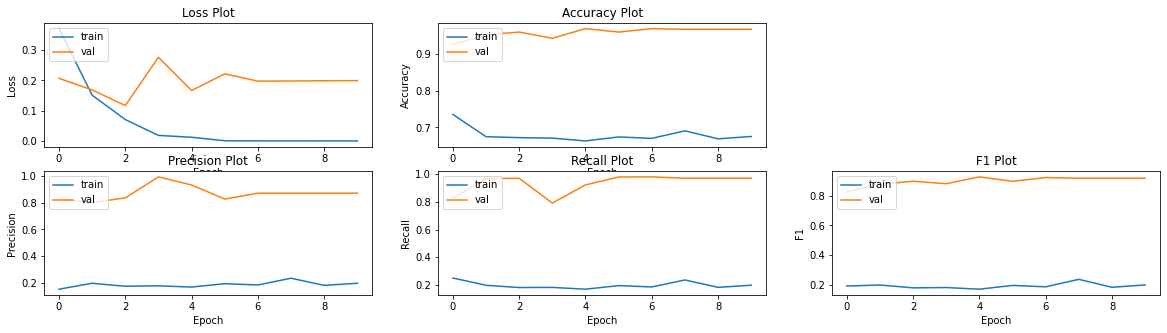

In [54]:
plt.subplot(2, 3, 1)
plt.plot(history['train_loss_list'])
plt.plot(history['val_loss_list'])
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(2, 3, 2)
plt.plot(history['train_acc_list'])
plt.plot(history['val_acc_list'])
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(2, 3, 4)
plt.plot(history['train_prec_list'])
plt.plot(history['val_prec_list'])
plt.title('Precision Plot')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(2, 3, 5)
plt.plot(history['train_recall_list'])
plt.plot(history['val_recall_list'])
plt.title('Recall Plot')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(2, 3, 6)
plt.plot(history['train_f1_list'])
plt.plot(history['val_f1_list'])
plt.title('F1 Plot')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

## Prediction

##### Run code below to create predict function for full concatenation (source || replies) model.

In [ ]:
def predict(model, dataloader, is_test=False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    model.eval()

    with torch.no_grad():
      all_logits = []

      if is_test:
          for input_ids, attention_masks in dataloader:
              
              input_ids = input_ids.to(device)
              attention_masks = attention_masks.to(device)
          
              outputs = model(input_ids,
                              attention_masks)
              
              logits = outputs.logits.detach().cpu().numpy()
              all_logits.append(logits)
      else:
          for input_ids, attention_masks, labels in dataloader:
              
              input_ids = input_ids.to(device)
              attention_masks = attention_masks.to(device)
          
              outputs = model(input_ids,
                              attention_masks)
              
              logits = outputs.logits.detach().cpu().numpy()
              all_logits.append(logits)
    
    predictions = np.argmax(np.concatenate(all_logits), axis=1).flatten()

    return list(predictions)

##### Run code below to create predict function for separate replies concatenation (source, reply1 || ... || replyn) model.

In [55]:
def predict(model, dataloader, is_test=False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    model.eval()

    with torch.no_grad():
      all_logits = []

      if is_test:
          for input_ids, token_type_ids, attention_masks in dataloader:
              
              input_ids = input_ids.to(device)
              token_type_ids = token_type_ids.to(device)
              attention_masks = attention_masks.to(device)
          
              outputs = model(input_ids=input_ids,
                              token_type_ids=token_type_ids,
                              attention_mask=attention_masks)
              
              logits = outputs.logits.detach().cpu().numpy()
              all_logits.append(logits)
      else:
          for input_ids, token_type_ids, attention_masks, labels in dataloader:
              
              input_ids = input_ids.to(device)
              token_type_ids = token_type_ids.to(device)
              attention_masks = attention_masks.to(device)
          
              outputs = model(input_ids=input_ids,
                              token_type_ids=token_type_ids,
                              attention_mask=attention_masks)
              
              logits = outputs.logits.detach().cpu().numpy()
              all_logits.append(logits)
    
    predictions = np.argmax(np.concatenate(all_logits), axis=1).flatten()

    return list(predictions)

##### Predict on specified set

In [56]:
# predict on development set
dev_predictions = predict(bert_model, dev_dataloader)

print(dev_predictions[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [57]:
# development prediction scores
print(f'The percentage of rumour labels in the development predictions is {dev_predictions.count(1)/len(dev_predictions)*100:.1f}%')

dev_acc, dev_prec, dev_recall, dev_f1 = calculate_scores(dev_predictions, dev_labels_np)
print(f'Development Scores:\t Accuracy ({dev_acc:.2f}), Precision({dev_prec:.2f}), Recall({dev_recall:.2f}), F1({dev_f1:.2f})\n')

The percentage of rumour labels in the development predictions is 19.3%
Development Scores:	 Accuracy (0.97), Precision(0.87), Recall(0.97), F1(0.92)



In [58]:
# predict on test set
test_predictions = predict(bert_model, test_dataloader, is_test=True)

print(test_predictions[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [59]:
print(f'The percentage of rumour labels in the test predictions is {test_predictions.count(1)/len(test_predictions)*100:.1f}%')

The percentage of rumour labels in the test predictions is 21.1%


##### Output a text file for submission

In [60]:
predictions = test_predictions
output_filename = 'test_predictions_31.csv'

header = ['Id', 'Predicted']
with open(output_filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i, pred in enumerate(predictions):
        data = [str(i), str(pred)]
        writer.writerow(data)
    f.close()

##### Prediction on covid set.

In [ ]:
covid_ids = get_ids('covid.data.txt')
flat_covid_ids = list(set([id_ for id_list in covid_ids for id_ in id_list]))

In [ ]:
covid_tweets = {}
def get_covid_tweets_from_api(ids, i_start=0):
    for i in range(i_start, len(ids), 100):
        split = ids[i:i+100]
        try:
            for tweet in api.lookup_statuses(split, tweet_mode='extended'):
                covid_tweets[tweet.id_str] = tweet.full_text
        except:
            return i

In [ ]:
i_stop = 0
while i_stop is not None:
    i_stop = get_covid_tweets_from_api(flat_covid_ids, i_start=i_stop)
    # print(i_stop)

In [ ]:
covid_ids_df = pd.DataFrame({'id': covid_tweets.keys(),
                             'text': covid_tweets.values()},
                             index=covid_tweets.keys())
covid_ids_df.head()

In [ ]:
# covid_ids_df.to_csv('covid_id_text.csv', header=True)

##### Load dataframe of covid ids and their text from covid_id_text.csv.

In [ ]:
covid_ids_df = pd.read_csv('covid_id_text.csv', index_col=0) 

In [ ]:
# predict on covid set
covid_pred_full_df = create_dataframe(covid_ids, None, covid_ids_df, include_labels=False)
covid_pred_dataloader = build_dataloader(covid_pred_full_df, bert_tokenizer, SequentialSampler, include_labels=False)
covid_predictions = predict(bert_model, covid_pred_dataloader, is_test=True)

print(covid_predictions[:10])

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]
